# Evaluation for Pycox model

In this notebook we introduce the use of `PycoxEvaluator` in the package through an example dataset and a model.
The first half of this notebook follows the procedure described in the Pycox [example](https://github.com/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In the following we will:

1. Load the METABRIC survival dataset and create a `LogisticHazard` model;
2. Train the model using training set;
3. Evaluate the performance using the concordance index, Brier score, Integrated Brier score, L1 loss, 1-calibration, and D-calibration.

## Import Dependencies
Note: You need `sklearn-pandas` for normalizing the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard

from Evaluator import PycoxEvaluator

In [2]:
%matplotlib inline

## Load Dataset
Set seed for torch and numpy for reproducibility

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

Load the dataset, split it into training (64%), validation (16%) and testing set (20%).
Then standardize the covariates.

In [4]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Build the model and train it.

In [5]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)
durations_train, events_train = get_target(df_train)

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.9332,	val_loss: 2.7593
1:	[0s / 0s],		train_loss: 2.6493,	val_loss: 2.5245
2:	[0s / 0s],		train_loss: 2.3807,	val_loss: 2.2181
3:	[0s / 0s],		train_loss: 2.0595,	val_loss: 1.8908
4:	[0s / 0s],		train_loss: 1.7514,	val_loss: 1.6019
5:	[0s / 0s],		train_loss: 1.5335,	val_loss: 1.4371
6:	[0s / 0s],		train_loss: 1.4379,	val_loss: 1.3759
7:	[0s / 0s],		train_loss: 1.3954,	val_loss: 1.3658
8:	[0s / 0s],		train_loss: 1.3906,	val_loss: 1.3619
9:	[0s / 0s],		train_loss: 1.3730,	val_loss: 1.3531
10:	[0s / 0s],		train_loss: 1.3605,	val_loss: 1.3486
11:	[0s / 0s],		train_loss: 1.3349,	val_loss: 1.3513
12:	[0s / 0s],		train_loss: 1.3153,	val_loss: 1.3488
13:	[0s / 0s],		train_loss: 1.3133,	val_loss: 1.3418
14:	[0s / 0s],		train_loss: 1.2988,	val_loss: 1.3432
15:	[0s / 0s],		train_loss: 1.3079,	val_loss: 1.3525
16:	[0s / 0s],		train_loss: 1.2976,	val_loss: 1.3565
17:	[0s / 0s],		train_loss: 1.2918,	val_loss: 1.3577
18:	[0s / 0s],		train_loss: 1.2900,	val_loss: 1.3594
19:

## Make the prediction.
`surv` is a Dataframe object. Row index represents the time coordinates, and each column represents a survival curve of one patient.

In [6]:
surv = model.interpolate(10).predict_surv_df(x_test)
surv.head(20)

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
0.000000,0.997888,0.998990,0.977142,0.996769,0.996701,0.997470,0.998884,0.999274,0.999061,0.996440,...,0.994224,0.994715,0.996657,0.997932,0.996396,0.995586,0.997912,0.999046,0.998036,0.987776
3.946667,0.990678,0.977079,0.967224,0.988112,0.975188,0.992005,0.997279,0.998690,0.972076,0.938016,...,0.982216,0.967455,0.982801,0.995717,0.985402,0.985974,0.988225,0.964453,0.974502,0.965598
7.893333,0.983467,0.955168,0.957305,0.979455,0.953674,0.986539,0.995674,0.998106,0.945092,0.879592,...,0.970207,0.940196,0.968944,0.993502,0.974408,0.976363,0.978538,0.929859,0.950968,0.943420
11.840000,0.976257,0.933257,0.947387,0.970799,0.932161,0.981074,0.994069,0.997523,0.918107,0.821168,...,0.958198,0.912936,0.955088,0.991287,0.963414,0.966751,0.968852,0.895265,0.927434,0.921242
15.786667,0.969046,0.911346,0.937468,0.962142,0.910647,0.975609,0.992463,0.996939,0.891123,0.762744,...,0.946189,0.885676,0.941231,0.989071,0.952420,0.957139,0.959165,0.860672,0.903899,0.899064
19.733334,0.961836,0.889435,0.927550,0.953485,0.889133,0.970144,0.990858,0.996355,0.864138,0.704320,...,0.934180,0.858417,0.927375,0.986856,0.941425,0.947527,0.949479,0.826078,0.880365,0.876886
23.680000,0.954625,0.867524,0.917631,0.944828,0.867620,0.964679,0.989253,0.995771,0.837153,0.645896,...,0.922171,0.831157,0.913518,0.984641,0.930431,0.937916,0.939792,0.791484,0.856831,0.854708
27.626667,0.947415,0.845613,0.907713,0.936171,0.846106,0.959213,0.987647,0.995187,0.810169,0.587472,...,0.910162,0.803897,0.899662,0.982426,0.919437,0.928304,0.930105,0.756891,0.833297,0.832530
31.573334,0.940204,0.823702,0.897794,0.927515,0.824592,0.953748,0.986042,0.994603,0.783184,0.529048,...,0.898153,0.776638,0.885805,0.980211,0.908443,0.918692,0.920419,0.722297,0.809763,0.810351
35.520000,0.932994,0.801792,0.887876,0.918858,0.803079,0.948283,0.984437,0.994019,0.756200,0.470624,...,0.886145,0.749378,0.871949,0.977995,0.897449,0.909080,0.910732,0.687704,0.786229,0.788173


## Build the evaluator.
Some arguments includes:
1. Training set information (`durations_train` and `events_train`) is optional if you don't need Brier score, integrated Brier score, and L1-margin loss.
2. `predicted_time_method` argument indicates whether using median or mean survival time as the predicted time.

In [7]:
eval = PycoxEvaluator(surv, durations_test, events_test, durations_train, events_train, predict_time_method="Median")

## Make some example plots
Plot the survival curves for subject 1, 10 and 100.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Survival probability'>)

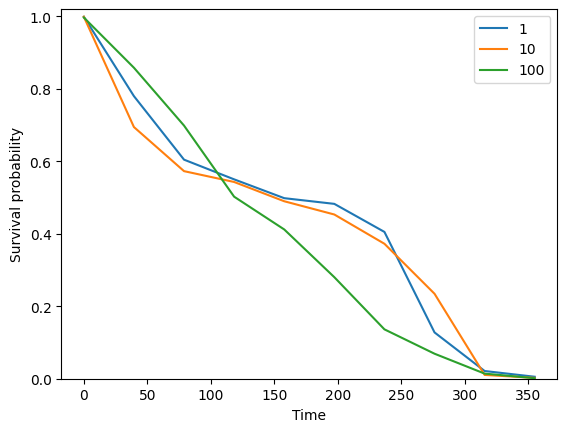

In [9]:
eval.plot_survival_curves([1, 10, 100])

## Calculate the concordance index.
`ties` argument indicates the way ties should be handled.
`ties="None"` will throw out all ties in true survival time and all ties in predict survival times (risk scores).
`ties="Time"` includes ties in true survival time but removes ties in predict survival times (risk scores).
`ties="Risk"` includes ties in predict survival times (risk scores) but not in true survival time.
`ties="All"` includes all ties.

In [10]:
cindex, concordant_pairs, total_pairs = eval.concordance(ties="None")
print("Concordance index is {}, meaning that the model can correctly order {} pairs among {} comparable pairs "
      "in the testing set.".format(cindex, concordant_pairs, total_pairs))

Concordance index is 0.6396413582602061, meaning that the model can correctly order 30177.0 pairs among 47178.0 comparable pairs in the testing set.


## Calculate the Brier score
Target time is at time 175.

In [11]:
bs = eval.brier_score(target_time=175)
print("Brier score at time 175 is {}.".format(bs))

Brier score at time 175 is 0.21502647117132093.


## Calculate the integrated Brier score (IBS)
You can specify the number of points `num_points` to integral. If it is not specify, the default setting will use the censored time points obtained from testing set.

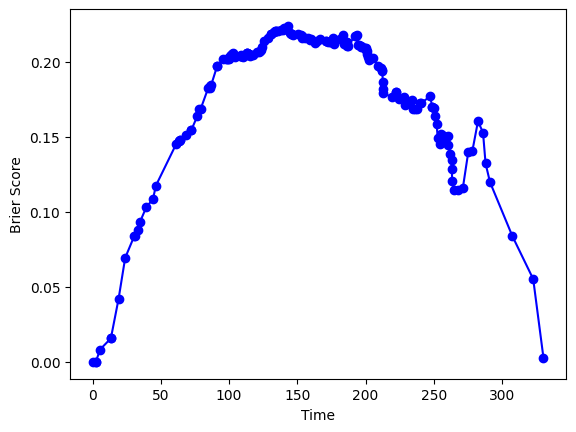

Integrated Brier score is 0.15237878376299174.


In [12]:
ibs = eval.integrated_brier_score(num_points=None, draw_figure=True)
print("Integrated Brier score is {}.".format(ibs))

# Calculate the MAE-Hinge loss
You can set `method` as `Hinge`, `Uncensored`, `Margin`, `IPCW-v1`, `IPCW-v2`, or `Pseudo_obs` for different MAE calculation.

In [13]:
mae_score = eval.mae(method='Hinge')
print("MAE-hinge loss is {}.".format(mae_score))

MAE-hinge loss is 61.36680426947983.


## Calculate the 1-Calibration
Run one calibration test at 50% time of the testing set.

In [14]:
t_time = round(np.percentile(durations_test, 50))
p_value, ob, exp = eval.one_calibration(target_time=t_time, method="DN")
if p_value >= 0.05:
    print("The model is one-calibrated at time {}.".format(t_time))
else:
    print("The model is not one-calibrated at time {}.".format(t_time))

The model is one-calibrated at time 113.


###  Plot the histogram for 1-Calibration.
As presented in [Effective Ways to Build and Evaluate Individual Survival Distributions](https://jmlr.csail.mit.edu/papers/v21/18-772.html)

In [15]:
# Reverse the bins to let it start from small to large observations
ob.reverse()
exp.reverse()

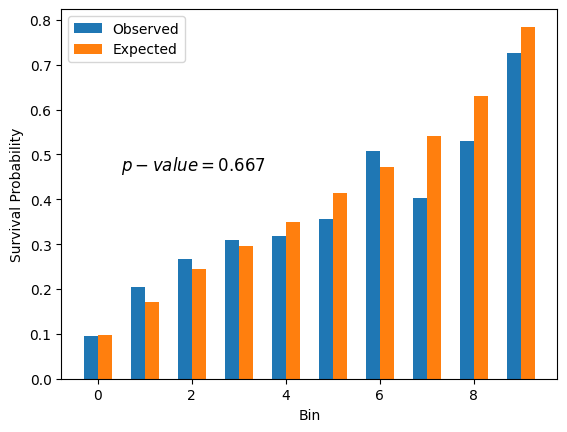

In [16]:
bins = np.arange(10)
plt.bar(bins - 0.15, ob, width=0.3, label="Observed")
plt.bar(bins + 0.15, exp, width=0.3, label="Expected")

plt.xlabel('Bin')
plt.ylabel('Survival Probability')
plt.text(0.5, 0.5, r'$p-value = {:.3f}$'.format(p_value), verticalalignment='top', horizontalalignment='left', fontsize=12, color='Black')
plt.legend()
plt.show()

## Calculate the distribution calibration (D-Calibration)

In [17]:
p_value_2, bin_statistics = eval.d_calibration()
if p_value_2 >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")

The model is d-calibrated!


In [18]:
# An ideal model should have bin statistics equally distributed. That means 0.1 for each value since we are using 10 bins.
bin_statistics /= bin_statistics.sum()
bin_statistics

array([0.09007619, 0.10882209, 0.0850901 , 0.08035892, 0.10668226,
       0.08903227, 0.09687332, 0.09677283, 0.11161959, 0.13467244])

### Plot the sideways histogram of D-Calibration
As presented in [Effective Ways to Build and Evaluate Individual Survival Distributions](https://jmlr.csail.mit.edu/papers/v21/18-772.html)

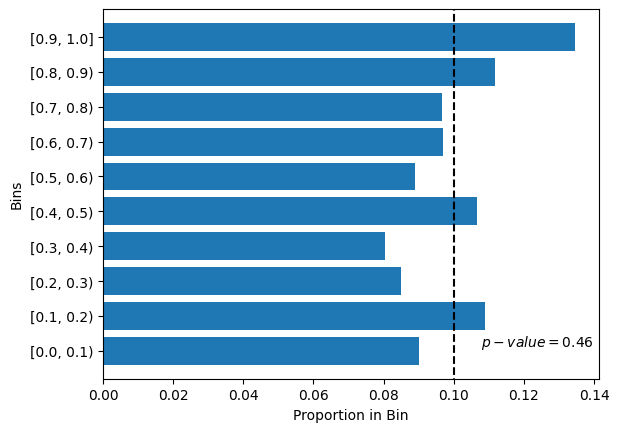

In [19]:
bars = ('[0.0, 0.1)', '[0.1, 0.2)', '[0.2, 0.3)', '[0.3, 0.4)', '[0.4, 0.5)',
        '[0.5, 0.6)', '[0.6, 0.7)', '[0.7, 0.8)', '[0.8, 0.9)', '[0.9, 1.0]')
y_pos = np.arange(len(bars))

fig, ax = plt.subplots()
ax.barh(y_pos, bin_statistics)
ax.plot(np.ones(len(bars)+2) * 0.1, np.arange(-1, len(bars)+1),  '--', color="black")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Proportion in Bin')
ax.set_ylabel('Bins')
ax.text(0.14, 0.5, r'$p-value = {:.2f}$'.format(p_value_2), verticalalignment='top', horizontalalignment='right', fontsize=10, color='Black')
plt.ylim([-0.8, 9.8])
plt.yticks(y_pos, bars)
plt.show()

### Plot the Q-Q plot of D-Calibration
As presented in [Countdown Regression: Sharp and Calibrated Survival Predictions](https://proceedings.mlr.press/v115/avati20a.html) and [Inverse-Weighted Survival Games](https://arxiv.org/abs/2111.08175)

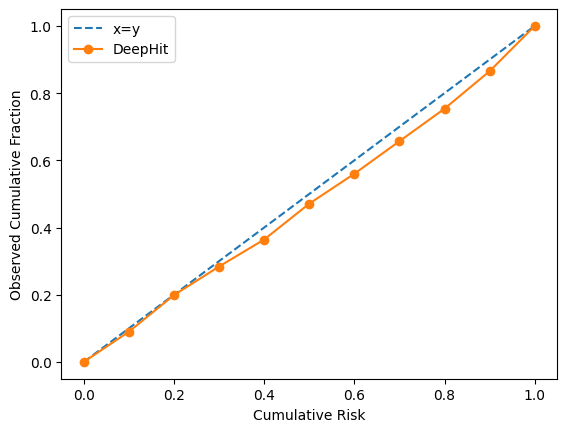

In [20]:
default = np.linspace(0, 1, 11)
plt.plot(default, default, linestyle='dashed', label="x=y")

fraction = np.concatenate((np.array([0]), bin_statistics))
plt.plot(default, fraction.cumsum(), 'o-', label="DeepHit")

plt.xlabel("Cumulative Risk")
plt.ylabel("Observed Cumulative Fraction")
plt.legend()
plt.show()